# Projekt z Genomiki Porównawczej

## Pobieranie danych

W ramach projektu odtworzę filogenezę wybranych cyjanobakterii. Analizę będę porównywać z wynikami z [tej](https://www.frontiersin.org/articles/10.3389/fmicb.2019.01612/full#h9) pracy.

Numery accession są zawarte w plik `accessions.txt`:

```bash
$ cat accessions.txt
CP003587
CP000240
CP017675
CP002198
BA000039
CP000828
AP008231
CP000393
CP003549
MKZR01000001
CP007754
CP003495
CP003597
BA000019
CP003659
CP003590
BX548175
BA000045
```

Ściąganie sekwencji:

In [366]:
import sys

from Bio import SeqIO
from Bio import Entrez

accessions = [x.strip() for x in open("accessions.txt", "r").readlines()]

Entrez.email = "stas.antonowicz@gmail.com"
entries = SeqIO.parse(
    Entrez.efetch(db="nucleotide", id=accessions, rettype="gb", retmode="text"), "gb"
)
for entry in entries:
    with open(f"gb/{entry.id}.gb", "w") as handle:
        SeqIO.write(entry, handle, "gb")

## Wyciąganie genów

Pliki genbankowe znajdują się w folderze `gb`. Otwórzmy je teraz.

In [379]:
import glob

records = []
from Bio import SeqIO

for file in glob.glob("gb/*"):
    records.append(list(SeqIO.parse(file, "gb"))[0])

In [380]:
len(records)

18

Spójrzmy, jak zadnotowane są genomy:

In [398]:
from collections import Counter

for record in records:
    print("id:", record.id)
    print("number of features:", len(record.features))
    print(Counter([x.type for x in record.features]))
    print()

id: CP000828.1
number of features: 12730
Counter({'gene': 6396, 'CDS': 6254, 'tRNA': 69, 'rRNA': 6, 'misc_RNA': 4, 'source': 1})

id: BX548175.1
number of features: 6760
Counter({'gene': 2969, 'CDS': 2915, 'misc_feature': 513, 'sig_peptide': 304, 'tRNA': 44, 'misc_RNA': 8, 'rRNA': 6, 'source': 1})

id: CP003549.1
number of features: 14731
Counter({'gene': 6911, 'CDS': 6609, 'sig_peptide': 1129, 'tRNA': 52, 'repeat_region': 15, 'rRNA': 9, 'ncRNA': 5, 'source': 1})

id: CP007754.1
number of features: 4661
Counter({'gene': 2330, 'CDS': 2287, 'tRNA': 40, 'rRNA': 3, 'source': 1})

id: CP017675.1
number of features: 6202
Counter({'gene': 3035, 'CDS': 3034, 'assembly_gap': 86, 'tRNA': 42, 'rRNA': 3, 'source': 1, 'misc_feature': 1})

id: CP003659.1
number of features: 11809
Counter({'gene': 5701, 'CDS': 5320, 'sig_peptide': 701, 'tRNA': 61, 'rRNA': 12, 'repeat_region': 10, 'ncRNA': 3, 'source': 1})

id: BA000045.2
number of features: 8963
Counter({'gene': 4433, 'CDS': 4430, 'mobile_element': 4

Ok, wszystkie genomy mają zadnotowane regiony kodujące (CDS).

In [396]:
def create_name(record):
    return f"{record.id}_{'_'.join(record.description.split(',')[0].split())}"

Teraz wyfiltrujemy z każdego genomu wszystkie geny (jako sekwencje białkowe):

In [399]:
from collections import defaultdict

genes = defaultdict(list)
for record in records:
    sequence = record.seq
    for feature in record.features:
        if feature.type == "CDS":
            try:
                genes[create_name(record)].append(feature.qualifiers["translation"][0])
            except KeyError:
                pass

I zapiszemy je do oddzielnych plików fasta:

In [190]:
for taxon, features in genes.items():
    with open(f"fasta/{taxon}.fa", "w") as handle:
        for i, feature in enumerate(features):
            handle.write(f">{taxon}_{i+1}\n")
            handle.write(feature + "\n")

## Klastrowanie

Do klastrowania użyję programu [MMseqs2](https://github.com/soedinglab/MMseqs2), pozwalającego na klastrowanie szybsze niż połączenie blast + MCL.

Najpierw muszę połączyć wszystkie pliki fasta w jeden (`all_genes.fasta`):

```bash
cd fasta
touch all_seqs.fasta
for f in *.fa; do cat $f >> all_genes.fasta; done
cd ..
```

Następnie wygenerować bazę danych:

```bash
mkdir clustering
cd clustering
mmseqs createdb ../fasta/all_genes.fasta DB
```

A potem dokonać klastrowania:

```bash
mmseqs cluster DB DB_clu tmp --threads 16 --min-seq-id 0.5 -c 0.8 --cov-mode 1
```

Opcja `--min-seq-id` jest raczej oczywista, natomiast opcja `-c` opisuje procent pokrycia sekwencji, zaś `--cov-mode` odpowiada za sposób obliczania tego pokrycia: w tym przypadku jest to opcja 1 z obrazka:

![obrazek](https://github.com/soedinglab/mmseqs2/wiki/images/cov_modes.png)

Na 16 wątkach zajęło to 1:05h.


## Analiza klastrów

Po pierwsze, trzeba dokonać konwersji do tsv, żeby można było lepiej zobaczyć co się dzieje z klastrami:

```bash
mmseqs createtsv DB DB DB_clu DB_clu.tsv
```

Zobaczmy, jak wyszło klastrowanie:


In [191]:
with open("clustering/DB_clu.tsv", "r") as handle:
    clusters = defaultdict(list)
    for line in handle:
        cluster_repr, cluster_member = line.strip().split()
        clusters[cluster_repr].append(cluster_member)

In [192]:
len([x for x in clusters.values() if len(x) > 3])

3773

Mamy 3773 klastrów mających więcej niż trzy sekwencje. Ale to nie wystarczy: klastry muszą mieć jednoznaczne nazwy genomów. Dodatkowo bez sensu jest klaster posiadający tylko jeden genom.

In [193]:
def trim_number(s):
    return "_".join(s.split("_")[:-1])

Liczność klastrów:

In [343]:
clusters_filtered = {
    cluster_repr: members
    for cluster_repr, members in clusters.items()
    if len(members) > 3
}

Jednoznaczne nazwy i jeden genom:

In [195]:
clusters_filtered = {
    cluster_repr: members
    for cluster_repr, members in clusters_filtered.items()
    if len(members) == len(set([trim_number(x) for x in members]))
}

In [344]:
import numpy as np

np.mean([len(x) for x in clusters_filtered.values()])

9.438908030744765

In [345]:
len(clusters_filtered)

3773

Ok, mamy 2657 klastrów. Być może dalej dokonamy filtrowania, na razie wyciągnę sekwencje do oddzielnych plików fasta.

W tym celu należy wygenerować plik z sekwencjami:

```bash
mmseqs createseqfiledb DB DB_clu DB_seqs_clustered
mmseqs result2flat DB DB DB_seqs_clustered ../fasta/clustered_seqs.fasta
```

Następnie sparsuję plik fasta. To nie takie proste, bo ma on specyficzną strukturę: kiedy zaczyna się wypisywanie klastra, są dwa identyfikatory po sobie: identyfikator centroidu klastra, a potem pierwszego członka danego klastra (jest to centroid). 

In [346]:
sequences_clustered = {}
.

In [347]:
len(sequences_clustered), len(clusters_filtered)

(3773, 3773)

Ok, jest tyle samo klastrów. Jeszcze dla porządku sprawdzę, czy listy nazw genów są takie same:

In [348]:
for key in sequences_clustered:
    v1 = sequences_clustered[key]
    v2 = clusters_filtered[key]
    if not (all([x1 == x2 for x1, x2 in zip([x[0] for x in v1], v2)])):
        print(f"Error at {key}")

Ok. Sprawdzę jeszcze, jakie są proporcje poszczególnych taksonów we wszystkich wybranych klastrach:

In [349]:
taxon_list = []
for _, vals in sequences_clustered.items():
    taxon_list.extend([trim_number(x[0]) for x in vals])
c = Counter(taxon_list)
print(len(c))
for taxon, count in c.items():
    print(count, taxon)

18
1427 AP008231.1_Synechococcus_elongatus
976 CP003495.1_Cyanobium_gracile
656 CP007754.1_Prochlorococcus_sp.
771 BX548175.1_Prochlorococcus_marinus
1499 BA000039.2_Thermosynechococcus_elongatus
2715 MKZR01000001.1_Moorea_producens
2322 CP000828.1_Acaryochloris_marina
2910 CP003597.1_Chroococcidiopsis_thermalis
3101 CP003549.1_Rivularia_sp.
2738 CP002198.1_Cyanothece_sp.
2560 CP003590.1_Pleurocapsa_sp.
2224 CP000393.1_Trichodesmium_erythraeum
1355 CP000240.1_Synechococcus_sp.
2947 CP003659.1_Anabaena_cylindrica
1390 CP017675.1_Gloeomargarita_lithophora
3046 BA000019.2_Nostoc_sp.
1543 BA000045.2_Gloeobacter_violaceus
1433 CP003587.1_Gloeobacter_kilaueensis


Zaraz, na początku było 18 taksonów. Wychodzi na to, że 2 były zbyt mało podobne, że się w ogóle sklastrowały. No cóż, kontynuuję analizę na 18-tu.

Co do proporcji to zobaczymy, mam nadzieję, żę jakoś fatalnie to nie wpłynie na wynik.

```bash
mkdir fasta/clusters
```

In [353]:
for i, (cluster_center, cluster_members) in enumerate(sequences_clustered.items()):
    with open(f"all_genes/fasta/clusters/cluster{i}.fasta", "w") as handle:
        for gene, sequence in cluster_members:
            handle.write(f">{gene}\n")
            handle.write(sequence + "\n")

Teraz zrobię przyrównania sekwencji. Wykorzystam program [MAFFT](https://mafft.cbrc.jp/alignment/software/) z opcją `--auto`.

```bash
mkdir fasta/alignments
cd fasta/clusters
for f in *.fasta; do mafft --thread 16 --auto $f  > ../alignments/$f; done
```

Zajęło to około 10 minut.

Następnie zbuduję drzewa korzystając z programu [RAxML](http://www.exelixis-lab.org/software.html).

Tutaj zawartość pliku `infer_trees.sh`, którego wywołam z nowo stworzonego folderu `trees` w taki sposób: `bash infer_trees.sh ../fasta/alignments`:
```bash
for f in $1/*.fasta
do
    filename=$(basename -- "$f")
    filename="${filename%.*}"
    mkdir $filename
    cd $filename
    raxmlHPC-PTHREADS-AVX -s ../$f -T 16 -m PROTGAMMAAUTO -n $filename.out -N 100 -x $RANDOM -p $RANDOM
    cd ..
done
```

Trochę wyjaśnienia, po co konkretne opcje:
- `-T 16`: liczba wątków
- `-m GTRGAMMA`: model ewolucji GTR z modelem gamma heteroniczności temp ewolucji na różnych pozycjach
- `-N autoMRE`: RAxML stara się automatycznie dobrać liczbę potwórzeń boostrap
- `-x $RANDOM`: losowy seed do analizy bootstrap, która dodatkowo jest szybsza, bo wykorzystuje jakąś heurystkę
- `-p $RANDOM`: losowy seed do startowych drzew opartych na największej parsymonii

Tutaj już trochę gorzej z szybkością liczenia: liczyło się 12 godzin i 22 minuty (na serwerze z wykorzystaniem 16 wątków). 

Teraz dla każdego klastra (rodziny genów) obliczę drzewo konsensusowe z powtórzeń bootstrap metodą majority rule consensus.

```bash
mkdir consensus
```

Zawartość pliku `compute_consensus.sh`, odpalanego z katalogu `trees`.

```bash
for f in cluster*
do
    cd $f
    raxmlHPC-PTHREADS-AVX -J MR -z "RAxML_bootstrap.${f}.out" -T 16 -m PROTGAMMAAUTO -n $f
    cp RAxML_MajorityRuleConsensusTree.$f ../consensus
    cd ..
done
```

To zajęło tylko 17 sekund.

Zrzucę teraz wszystkie drzewa to jednego pliku:

```bash
cd consensus
touch all_consensus_trees.txt
for f in RAxML_MajorityRuleConsensusTree.cluster*; do cat $f >> all_consensus_trees.txt; done
cd ..
```




In [370]:
from Bio import Phylo

trees = list(Phylo.parse("all_genes/trees/consensus/all_consensus_trees.txt", "newick"))

In [372]:
len(trees)

3773

Usunę teraz wszystko co zbędne z drzew: zostawię same topologie

In [373]:
import re
import copy

trees_2 = copy.deepcopy(trees)


for i, tree in enumerate(trees_2):
    for nonterminal in tree.get_nonterminals():
        nonterminal.comment = None
        nonterminal.branch_length = None
    for terminal in tree.get_terminals():
        terminal.name = trim_number(terminal.name)

In [374]:
from Bio.Phylo import NewickIO

writer = NewickIO.Writer([tre for tre in trees_2 if tre.is_bifurcating()])

In [375]:
with open("superdrzewa_soft/all_gene_trees.txt", "w") as handle:
    for newick_tree in writer.to_strings(plain=True):
        handle.write(newick_tree + "\n")

In [376]:
parser = NewickIO.Parser.from_string(
    "(((CP003495.1_Cyanobium_gracile,(((BA000039.2_Thermosynechococcus_elongatus,CP017675.1_Gloeomargarita_lithophora),(((((CP000393.1_Trichodesmium_erythraeum,MKZR01000001.1_Moorea_producens),(CP002198.1_Cyanothece_sp.,CP003590.1_Pleurocapsa_sp.)),((CP003549.1_Rivularia_sp.,(BA000019.2_Nostoc_sp.,CP003659.1_Anabaena_cylindrica)),CP003597.1_Chroococcidiopsis_thermalis)),CP000828.1_Acaryochloris_marina),(CP000240.1_Synechococcus_sp.,(CP003587.1_Gloeobacter_kilaueensis,BA000045.2_Gloeobacter_violaceus)))),AP008231.1_Synechococcus_elongatus)),BX548175.1_Prochlorococcus_marinus),CP007754.1_Prochlorococcus_sp.)"
)
final_tree = next(parser.parse())

In [377]:
print(final_tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade()
            Clade()
                Clade(name='CP003495.1_Cyanobium_gracile')
                Clade()
                    Clade()
                        Clade()
                            Clade(name='BA000039.2_Thermosynechococcus_elongatus')
                            Clade(name='CP017675.1_Gloeomargarita_lithophora')
                        Clade()
                            Clade()
                                Clade()
                                    Clade()
                                        Clade()
                                            Clade(name='CP000393.1_Trichodesmium_erythraeum')
                                            Clade(name='MKZR01000001.1_Moorea_producens')
                                        Clade()
                                            Clade(name='CP002198.1_Cyanothece_sp.')
                                            Clade(name='CP003590.1_Pleurocapsa_sp.')
               

In [378]:
final_tree.root_with_outgroup(
    ["CP003587.1_Gloeobacter_kilaueensis", "BA000045.2_Gloeobacter_violaceus"]
)
Phylo.draw_ascii(final_tree)

                           ___ CP007754.1_Prochlorococcus_sp.
                       ___|
                   ___|   |___ BX548175.1_Prochlorococcus_marinus
                  |   |
              ____|   |___ CP003495.1_Cyanobium_gracile
             |    |
          ___|    |___ AP008231.1_Synechococcus_elongatus
         |   |
         |   |     ___ BA000039.2_Thermosynechococcus_elongatus
         |   |____|
         |        |___ CP017675.1_Gloeomargarita_lithophora
         |
         |                 ___ CP000393.1_Trichodesmium_erythraeum
         |             ___|
      ___|            |   |___ MKZR01000001.1_Moorea_producens
     |   |         ___|
     |   |        |   |    ___ CP002198.1_Cyanothece_sp.
     |   |        |   |___|
     |   |        |       |___ CP003590.1_Pleurocapsa_sp.
     |   |    ____|
     |   |   |    |        ___ CP003549.1_Rivularia_sp.
     |   |   |    |    ___|
  ___|   |   |    |   |   |    ____ BA000019.2_Nostoc_sp.
 |   |   |___|    |___|   |__

In [321]:
!mkdir trees/consensus_biopython

In [335]:
import glob
import os

all_trees = []
trees_for_fasturec = []
for fpath in glob.glob("trees/cluster*"):
    folder_name = os.path.split(fpath)[1]
    trees = Phylo.parse(f"{fpath}/RAxML_bootstrap.{folder_name}.out", "newick")
    consensus_tree = majority_consensus(trees, cutoff=0.25)
    all_trees.append(consensus_tree)
    Phylo.write(
        consensus_tree, f"trees/consensus_biopython/{folder_name}.nwk", "newick"
    )
    for nonterminal in consensus_tree.get_nonterminals():
        nonterminal.comment = None
        nonterminal.branch_length = None
    trees_for_fasturec.append(consensus_tree)

In [336]:
len([t for t in trees_for_fasturec if t.is_bifurcating()])

1597

In [337]:
writer = NewickIO.Writer([tre for tre in trees_for_fasturec if tre.is_bifurcating()])
with open("superdrzewa_soft/all_trees_for_fasturec_biopython.txt", "w") as handle:
    for newick_tree in writer.to_strings(plain=True):
        handle.write(newick_tree + "\n")

In [381]:
parser = NewickIO.Parser.from_string(
    "(((((BA000039.2_Thermosynechococcus_elongatus,(((((CP003590.1_Pleurocapsa_sp.,CP002198.1_Cyanothece_sp.),(CP000393.1_Trichodesmium_erythraeum,MKZR01000001.1_Moorea_producens)),(((BA000019.2_Nostoc_sp.,CP003659.1_Anabaena_cylindrica),CP003549.1_Rivularia_sp.),CP003597.1_Chroococcidiopsis_thermalis)),CP000828.1_Acaryochloris_marina),((CP000240.1_Synechococcus_sp.,CP017675.1_Gloeomargarita_lithophora),(CP003587.1_Gloeobacter_kilaueensis,BA000045.2_Gloeobacter_violaceus)))),AP008231.1_Synechococcus_elongatus),CP003495.1_Cyanobium_gracile),BX548175.1_Prochlorococcus_marinus),CP007754.1_Prochlorococcus_sp.)"
)
final_tree = next(parser.parse())

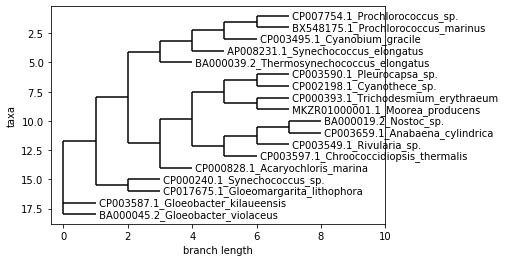

In [397]:
final_tree.root_with_outgroup(
    ["CP003587.1_Gloeobacter_kilaueensis", "BA000045.2_Gloeobacter_violaceus",]
)
Phylo.draw(final_tree)

In [394]:
tree_name = set([x.name.split(".")[0] for x in final_tree.get_terminals()])
file_names = Counter([x.strip() for x in open("accessions.txt", "r")])
print(file_names)

Counter({'CP002198': 2, 'CP000240': 1, 'CP017675': 1, 'BA000039': 1, 'CP000828': 1, 'AP008231': 1, 'CP000393': 1, 'CP003549': 1, 'MKZR01000001': 1, 'CP007754': 1, 'CP003495': 1, 'CP003597': 1, 'BA000019': 1, 'CP003659': 1, 'CP003590': 1, 'BX548175': 1, 'BA000045': 1})


In [358]:
!ls -l all_genes/trees | wc -l

210


In [360]:
(3773 - 210) * (60 / 210) / 60

16.966666666666665